In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

from evaluation import get_cm_sklearn, print_metrics
from preprocessing import TrainingPreProcessor

RANDOM_STATE = 0

train_set = pd.read_csv("input/train.csv")

training_preprocessor = TrainingPreProcessor()
training_preprocessor.fit(train_set, ignore_columns=["CLIENTNUM"])

X, y = training_preprocessor.transform(train_set)
class_weight = training_preprocessor.class_weight

kfold = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)

## Recuperação dos melhores modelos encontrados por gridsearch

In [2]:
logistic_regression_model = LogisticRegression(
    random_state=RANDOM_STATE,
    class_weight=class_weight,
    solver="saga",
    **{"C": 0.1, "max_iter": 1000, "penalty": "l2", "tol": 0.0001}
)

svc_model = SVC(
    random_state=RANDOM_STATE,
    class_weight=class_weight,
    **{"C": 1.0, "kernel": "rbf", "max_iter": 10000, "tol": 0.001}
)

rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight=class_weight,
    **{
        "criterion": "entropy",
        "max_depth": 7,
        "max_features": "sqrt",
        "n_estimators": 50,
    }
)
xgboost_classifier = XGBClassifier(
    seed=RANDOM_STATE,
    colsample_bytree=0.975,
    gamma=0.1,
    max_depth=4,
    min_child_weight=1,
    n_estimators=400,
    subsample=0.975,
)
catboost_classifier = CatBoostClassifier(
    random_state=RANDOM_STATE,
    class_weights=class_weight,
    **{"iterations": 300, "learning_rate": 0.05, "max_depth": 5}
)


## Treinando e avaliando um ensemble de votação

In [3]:
voting_ensemble = VotingClassifier(
    estimators=[
        ("logistic_regression", logistic_regression_model),
        ("svc", svc_model),
        ("random_forest", rf_model),
        ("xgboost", xgboost_classifier),
        ("catboost", catboost_classifier)
    ],
    voting="hard",
)

In [4]:
metrics = {
    "balanced_accuracy": [],
    "accuracy": [],
    "f1": [],
    "roc_auc": [],
}
for train_index, val_index in kfold.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    xgb_class_weight = compute_sample_weight(class_weight="balanced", y=y_train)

    voting_ensemble.fit(X_train, y_train)
    voting_ensemble.estimators_[3].fit(X_train, y_train, sample_weight=xgb_class_weight)

    y_val_pred = voting_ensemble.predict(X_val)
    metrics["balanced_accuracy"].append(balanced_accuracy_score(y_val, y_val_pred))
    metrics["accuracy"].append(accuracy_score(y_val, y_val_pred))
    metrics["f1"].append(f1_score(y_val, y_val_pred))
    metrics["roc_auc"].append(roc_auc_score(y_val, y_val_pred))
for metric, values in metrics.items():
    print(
        f"{metric}: {np.array(metrics[metric]).mean():.4f} +- {np.array(metrics[metric]).std():.4f}"
    )

0:	learn: 0.6447128	total: 144ms	remaining: 42.9s
1:	learn: 0.5999362	total: 148ms	remaining: 22.1s
2:	learn: 0.5606216	total: 152ms	remaining: 15.1s
3:	learn: 0.5246820	total: 156ms	remaining: 11.5s
4:	learn: 0.4990297	total: 159ms	remaining: 9.4s
5:	learn: 0.4745676	total: 163ms	remaining: 7.98s
6:	learn: 0.4528667	total: 167ms	remaining: 6.99s
7:	learn: 0.4311228	total: 171ms	remaining: 6.25s
8:	learn: 0.4168847	total: 175ms	remaining: 5.65s
9:	learn: 0.4037709	total: 178ms	remaining: 5.17s
10:	learn: 0.3871987	total: 182ms	remaining: 4.79s
11:	learn: 0.3732614	total: 187ms	remaining: 4.48s
12:	learn: 0.3648340	total: 190ms	remaining: 4.2s
13:	learn: 0.3565544	total: 194ms	remaining: 3.95s
14:	learn: 0.3466524	total: 197ms	remaining: 3.74s
15:	learn: 0.3371959	total: 201ms	remaining: 3.57s
16:	learn: 0.3303802	total: 205ms	remaining: 3.41s
17:	learn: 0.3190833	total: 208ms	remaining: 3.27s
18:	learn: 0.3137050	total: 212ms	remaining: 3.13s
19:	learn: 0.3058391	total: 215ms	remaining

## Treinando e avaliando (sobre validação) um ensemle de empilhamento

In [5]:
metrics = {
    "balanced_accuracy": [],
    "accuracy": [],
    "f1": [],
    "roc_auc": [],
}
for train_index, val_index in kfold.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    xgb_class_weight = compute_sample_weight(class_weight="balanced", y=y_train)

    logistic_regression_model.fit(X_train, y_train)
    svc_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    xgboost_classifier.fit(X_train, y_train, sample_weight=xgb_class_weight)
    catboost_classifier.fit(X_train, y_train)

    stacking_ensemble = StackingClassifier(
        estimators=[
            ("logistic_regression", logistic_regression_model),
            ("svc", svc_model),
            ("random_forest", rf_model),
            ("xgboost", xgboost_classifier),
            ("catboost", catboost_classifier),
        ],
        final_estimator=LogisticRegression(random_state=RANDOM_STATE),
        cv="prefit",
    )

    stacking_ensemble.fit(X_train, y_train)

    y_val_pred = voting_ensemble.predict(X_val)
    metrics["balanced_accuracy"].append(balanced_accuracy_score(y_val, y_val_pred))
    metrics["accuracy"].append(accuracy_score(y_val, y_val_pred))
    metrics["f1"].append(f1_score(y_val, y_val_pred))
    metrics["roc_auc"].append(roc_auc_score(y_val, y_val_pred))
for metric, values in metrics.items():
    print(
        f"{metric}: {np.array(metrics[metric]).mean():.4f} +- {np.array(metrics[metric]).std():.4f}"
    )

0:	learn: 0.6447128	total: 4.67ms	remaining: 1.4s
1:	learn: 0.5999362	total: 8.98ms	remaining: 1.34s
2:	learn: 0.5606216	total: 13.3ms	remaining: 1.32s
3:	learn: 0.5246820	total: 17.8ms	remaining: 1.32s
4:	learn: 0.4990297	total: 23ms	remaining: 1.36s
5:	learn: 0.4745676	total: 27.2ms	remaining: 1.33s
6:	learn: 0.4528667	total: 32.1ms	remaining: 1.34s
7:	learn: 0.4311228	total: 37ms	remaining: 1.35s
8:	learn: 0.4168847	total: 42.6ms	remaining: 1.38s
9:	learn: 0.4037709	total: 47.8ms	remaining: 1.39s
10:	learn: 0.3871987	total: 52.5ms	remaining: 1.38s
11:	learn: 0.3732614	total: 56.5ms	remaining: 1.36s
12:	learn: 0.3648340	total: 61.6ms	remaining: 1.36s
13:	learn: 0.3565544	total: 66.6ms	remaining: 1.36s
14:	learn: 0.3466524	total: 70.3ms	remaining: 1.33s
15:	learn: 0.3371959	total: 74.3ms	remaining: 1.32s
16:	learn: 0.3303802	total: 78.8ms	remaining: 1.31s
17:	learn: 0.3190833	total: 83.1ms	remaining: 1.3s
18:	learn: 0.3137050	total: 86.9ms	remaining: 1.28s
19:	learn: 0.3058391	total: 

### Comparando melhor modelo e baseline

O melhor modelo encontrado foi o stacking de todos os modelos com hiperparametros calibrados.

In [6]:
test_set = pd.read_csv("input/test.csv")
X_test, y_test = training_preprocessor.transform(test_set)

In [7]:
xgb_class_weight = compute_sample_weight(class_weight="balanced", y=y)

logistic_regression_model.fit(X, y)
svc_model.fit(X, y)
rf_model.fit(X, y)
xgboost_classifier.fit(X, y, sample_weight=xgb_class_weight)
catboost_classifier.fit(X, y)

stacking_ensemble = StackingClassifier(
    estimators=[
        ("logistic_regression", logistic_regression_model),
        ("svc", svc_model),
        ("random_forest", rf_model),
        ("xgboost", xgboost_classifier),
        ("catboost", catboost_classifier),
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv="prefit",
)

stacking_ensemble.fit(X, y)

0:	learn: 0.6457202	total: 4.97ms	remaining: 1.49s
1:	learn: 0.5998631	total: 8.95ms	remaining: 1.33s
2:	learn: 0.5620370	total: 12.8ms	remaining: 1.27s
3:	learn: 0.5271172	total: 17.2ms	remaining: 1.27s
4:	learn: 0.4996344	total: 22.4ms	remaining: 1.32s
5:	learn: 0.4762069	total: 26.2ms	remaining: 1.28s
6:	learn: 0.4543191	total: 30.4ms	remaining: 1.27s
7:	learn: 0.4325027	total: 35.3ms	remaining: 1.29s
8:	learn: 0.4160071	total: 40.8ms	remaining: 1.32s
9:	learn: 0.4013742	total: 44.5ms	remaining: 1.29s
10:	learn: 0.3901922	total: 48.8ms	remaining: 1.28s
11:	learn: 0.3763558	total: 53.3ms	remaining: 1.28s
12:	learn: 0.3672238	total: 58.1ms	remaining: 1.28s
13:	learn: 0.3597148	total: 61.8ms	remaining: 1.26s
14:	learn: 0.3497061	total: 66.4ms	remaining: 1.26s
15:	learn: 0.3378960	total: 71ms	remaining: 1.26s
16:	learn: 0.3305672	total: 75.7ms	remaining: 1.26s
17:	learn: 0.3223792	total: 79.6ms	remaining: 1.25s
18:	learn: 0.3160604	total: 84.4ms	remaining: 1.25s
19:	learn: 0.3093247	tot

StackingClassifier(cv='prefit',
                   estimators=[('logistic_regression',
                                LogisticRegression(C=0.1,
                                                   class_weight={0: 3.1157692307692306,
                                                                 1: 0.5955741802676077},
                                                   max_iter=1000,
                                                   random_state=0,
                                                   solver='saga')),
                               ('svc',
                                SVC(class_weight={0: 3.1157692307692306,
                                                  1: 0.5955741802676077},
                                    max_iter=10000, random_state=0)),
                               ('random_forest',
                                RandomForestClassifier(class_weight={0: 3...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=400, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x00000232FD7D3EE0>)],
                   final_estimator=LogisticRegression(random_state=0))

Accuracy: 0.9689042448173741
Balanced Accuracy: 0.9456516065395546
F1: 0.9814323607427057
RoC AuC: 0.9456516065395546


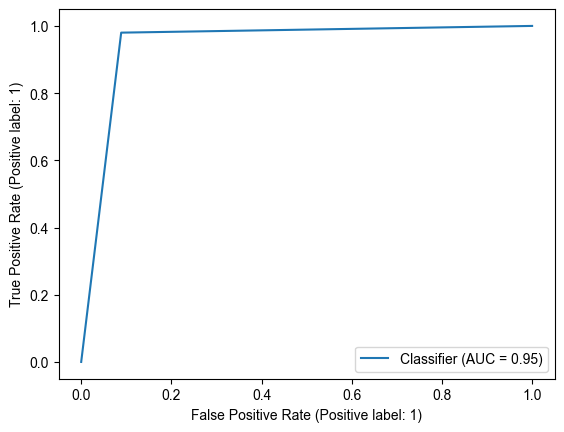

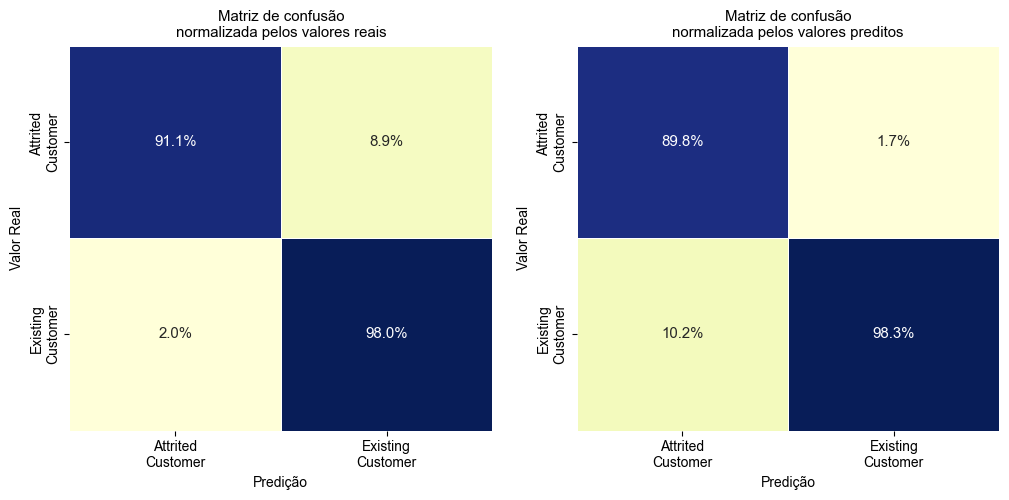

In [8]:
y_pred_test_stacking = stacking_ensemble.predict(X_test)

print_metrics(y_test, y_pred_test_stacking)

get_cm_sklearn(
    y_test,
    y_pred_test_stacking,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)

In [9]:
baseline_svc_model = SVC(random_state=RANDOM_STATE, class_weight=class_weight)
baseline_svc_model.fit(X_train, y_train)

SVC(class_weight={0: 3.1157692307692306, 1: 0.5955741802676077}, random_state=0)

Accuracy: 0.9170779861796644
Balanced Accuracy: 0.914751076816188
F1: 0.9489051094890512
RoC AuC: 0.9147510768161881


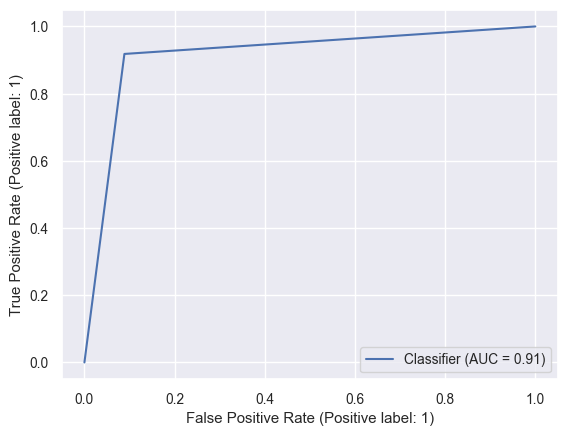

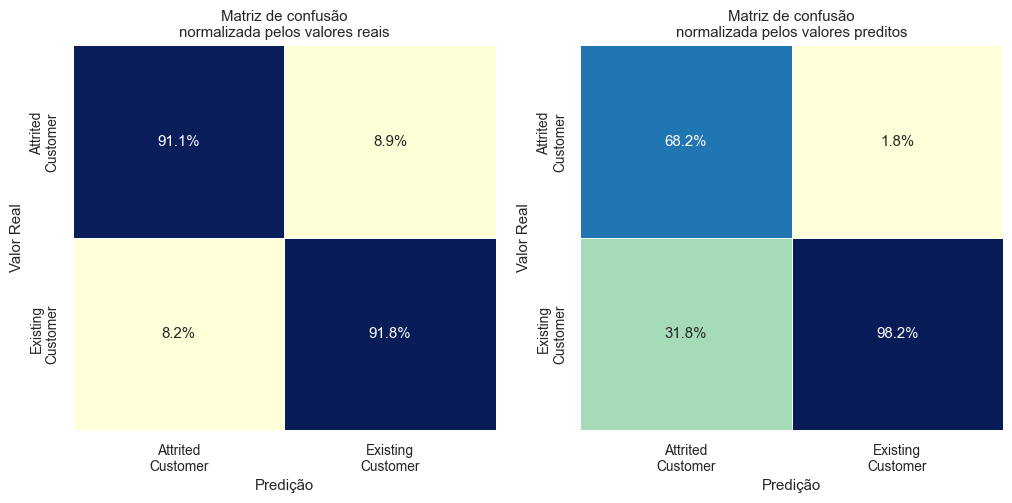

In [13]:
y_pred_test_svc = baseline_svc_model.predict(X_test)

print_metrics(y_test, y_pred_test_svc)

get_cm_sklearn(
    y_test,
    y_pred_test_svc,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)